# HuBMAP - Hacking the Human Vasculature
The goal of this competition is to segment instances of microvascular structures, including capillaries, arterioles, and venules. The task is to create a model trained on 2D PAS-stained histology images from healthy human kidney tissue slides.

# Libraries

In [39]:
!pip install segmentation-models-pytorch

In [40]:
!pip install pipreqsnb

In [41]:
import json # Json data handling utilities
import os # OS utilities
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # Plotting

# ML framework
import torch 
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm.auto import tqdm

# Segmentation models and utilities
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

# Read TIF files
import rasterio
from rasterio.plot import show

# Image augmentation 
import albumentations as A 

# Constants

In [42]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

IMG_SIZE = 512

BATCH_SIZE = 8
EPOCHS = 15
LR = 1e-03

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

MODEL_FILE = '/kaggle/working/best_hubmap_model.pt'

# Data paths

In [43]:
BASE_DIR = '/kaggle/input/hubmap-hacking-the-human-vasculature/'
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
TEST_DIR = os.path.join(BASE_DIR, 'test')
POLYGONS_FILE = os.path.join(BASE_DIR, 'polygons.jsonl')
TILE_META_FILE = os.path.join(BASE_DIR, 'tile_meta.csv')
WSI_META_FILE = os.path.join(BASE_DIR, 'wsi_meta.csv')

Both, ```TRAIN_DIR``` and ```TEST_DIR``` are folders containing TIFF images of the tiles. Each tile is 512x512 in size.

```POLYGONS_FILE``` is a file containing polygonal segmentation masks in JSONL format, available for Dataset 1 and Dataset 2.

```TILE_META_FILE``` is a file containing metadata for each image.

```WSI_META_FILE``` is a file containing metadata for the Whole Slide Images the tiles were extracted from.

More detailed information is available at [competition data page](https://www.kaggle.com/competitions/hubmap-hacking-the-human-vasculature/data).

# EDA

Before doing preprocess and prepare our data, I will like to explore the data we are going to work with.

In [44]:
wsi_meta = pd.read_csv(WSI_META_FILE)
wsi_meta

,source_wsi,age,sex,race,height,weight,bmi
0,1,58,F,W,160.0,59.0,23.0
1,2,56,F,W,175.2,139.6,45.5
2,3,73,F,W,162.3,87.5,33.2
3,4,53,M,B,166.0,73.0,26.5


In [45]:
tile_meta = pd.read_csv(TILE_META_FILE)

print('Number of rows')
print(len(tile_meta.index))

print('\nFirst five rows')
print(tile_meta.head(5))

Number of rows
7033

First five rows
             id  source_wsi  dataset      i      j
0  0006ff2aa7cd           2        2  16896  16420
1  000e79e206b7           6        3  10240  29184
2  00168d1b7522           2        2  14848  14884
3  00176a88fdb0           7        3  14848  25088
4  0033bbc76b6b           1        1  10240  43008


In [46]:
print('Statistics')
tile_meta.describe()

Statistics


,source_wsi,dataset,i,j
count,7033.000000,7033.000000,7033.000000,7033.000000
mean,8.205744,2.707806,14296.542585,23227.014930
std,4.004251,0.571724,5946.054578,10644.032931
min,1.000000,1.000000,1536.000000,2560.000000
25%,6.000000,3.000000,9728.000000,15265.000000
50%,9.000000,3.000000,13824.000000,22528.000000
75%,12.000000,3.000000,18944.000000,29656.000000
max,14.000000,3.000000,30208.000000,52753.000000


In [47]:
with open(POLYGONS_FILE, 'r') as json_file:
    annotations = [json.loads(line) for line in json_file]

In [48]:
len(annotations)

1633

As we can see, while our train directory contains 7033 images, only 1633 of them are annotated, so our training data is reduced from 7033 to 1633.

# Custom PyTorch Dataset and DataLoader
In order to join the images with their corresponding annotations we are going to create a custom dataset using Dataset PyTorch class, this will also be useful to create a DataLoader.

## Augmentation function

In [49]:
def get_train_augs():
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
    ])

In [50]:
class HubmapDataset(Dataset):
    def __init__(self, img_dir, annotations_file, augmentations=None):
        """
        Parameters
        img_dir: Image directory (os.path)
        annotations_file: File that stores the annotations of each image (os.path)
        augmentations: Augmentations operations to apply to image.
        
        Return
        image: Image read as PyTorch Tensor 
        mask: Mask read as PyTorch Tensor
        """
        with open(annotations_file, 'r') as json_file:
            self.annotations = [json.loads(line) for line in json_file]
            
        self.img_dir = img_dir
        self.augmentations = augmentations

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, f"{self.annotations[idx]['id']}.tif")
        
        with rasterio.open(img_path) as image:
            # Shape: [C, H, W]
            image_array = image.read()                                            
                    
        # Initialize mask
        mask = np.zeros((IMG_SIZE, IMG_SIZE), dtype=np.float32)
        
        for annot in annotations[idx]['annotations']:
            if annot['type'] == 'blood_vessel':
                for cord in annot['coordinates']:
                    # Note: Here height value is in position 1
                    #       and width value is in position 0
                    h = [i[1] for i in cord]
                    w = [i[0] for i in cord]
                
                    mask[h, w] = 1    
                    
        # (H, W) -> (1, H, W)
        mask = np.reshape(mask, [1, *mask.shape])
        
        if self.augmentations is not None:
            # Note: image_array is already a numpy array.
            data = self.augmentations(image=image_array, mask=mask)
            image = data['image']
            mask = data['mask']
        
        # Scaling
        image = torch.from_numpy(image.copy()) / 255.0
        mask = torch.from_numpy(mask.copy())

        return image, mask

Let's test our HubmapDataset class.

In [51]:
dataset = HubmapDataset(TRAIN_DIR, POLYGONS_FILE, get_train_augs())

In [52]:
def plot_sample(hubmap_dataset, n_sample):
    n_rows = n_sample
    n_cols = 3
    ratio = 2
    
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*ratio, n_rows*ratio))
    
    for i in range(n_sample):
        # Gather samples
        image, mask = hubmap_dataset[i]
    
        # shape (H, W, C)
        image = image.permute(1, 2, 0).cpu().numpy() 
        mask = mask.permute(1, 2, 0).cpu().numpy()

        # Plot
        if n_sample == 1:
            axs[0].imshow(image, cmap='gray'); axs[0].axis('off')
            axs[1].imshow(mask, cmap='gray'); axs[1].axis('off')
            axs[2].imshow(image, cmap='gray', interpolation=None); axs[2].axis('off')
            axs[2].imshow(mask, cmap='rainbow', alpha=0.6, interpolation=None)
            
            # Set subplot title
            axs[0].set_title('Image')
            axs[1].set_title('Mask')
            axs[2].set_title('Overlay')
            
            for ax in axs:
                # Hide X and Y axes label marks
                ax.xaxis.set_tick_params(labelbottom=False)
                ax.yaxis.set_tick_params(labelleft=False)

                # Hide X and Y axes tick marks
                ax.set_xticks([])
                ax.set_yticks([])
        else:
            axs[i, 0].imshow(image, cmap='gray'); axs[i, 0].axis('off')
            axs[i, 1].imshow(mask, cmap='gray'); axs[i, 1].axis('off')
            axs[i, 2].imshow(image, cmap='gray'); axs[i, 2].axis('off')
            axs[i, 2].imshow(mask, cmap='rainbow', alpha=0.6)
            
            # Set column title
            cols_label = ['Image', 'Mask', 'Overlay']
            pad = 10
            
            for ax, col_label in zip(axs[0], cols_label):
                ax.annotate(col_label, xy=(0.5, 1), xytext=(0, pad),
                            xycoords='axes fraction', textcoords='offset points', 
                            ha='center', va='baseline')
            
            for ax in axs[i, :]:
                # Hide X and Y axes label marks
                ax.xaxis.set_tick_params(labelbottom=False)
                ax.yaxis.set_tick_params(labelleft=False)

                # Hide X and Y axes tick marks
                ax.set_xticks([])
                ax.set_yticks([])

/opt/conda/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


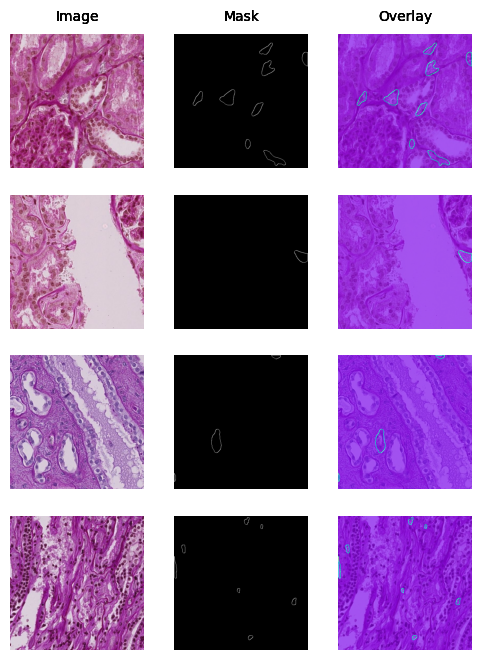

In [53]:
plot_sample(dataset, 4)

Let's split our current dataset into training data and validation data

In [54]:
train_data, valid_data = random_split(dataset, [0.8, 0.2])

In [55]:
print(f'No. of images in train_data: {len(train_data)}')
print(f'No. of images in val_data: {len(valid_data)}')

No. of images in train_data: 1307
No. of images in val_data: 326


Now, it's turn to create our DataLoader.
DataLoader is an iterable that abstracts the complexity of how we input the data to the model.

In [56]:
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=True)

In [57]:
print(f'Total no. of batches in trainloader: {len(train_loader)}')
print(f'Total no. of batches in validloader: {len(valid_loader)}')

Total no. of batches in trainloader: 164
Total no. of batches in validloader: 41


In [58]:
for image, mask in train_loader:
    break

print(f'One batch image shape: {image.shape}')
print(f'One batch mask shape: {mask.shape}')

One batch image shape: torch.Size([8, 3, 512, 512])
One batch mask shape: torch.Size([8, 1, 512, 512])


# Segmentation Model


In [59]:
class SegmentationModel(nn.Module):
    def __init__(self):
        super(SegmentationModel, self).__init__()
        self.arch = smp.Unet(
            encoder_name=ENCODER, 
            encoder_weights=WEIGHTS,
            in_channels=3,
            classes=1,
            activation=None
        )

    def forward(self, images, masks=None):
        logits = self.arch(images)

        if masks is not None:
            dice = DiceLoss(mode='binary')(logits, masks)
            bce = nn.BCEWithLogitsLoss()(logits, masks)

            return logits, dice + bce

        return logits

In [60]:
model = SegmentationModel()

if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)

model.to(DEVICE); # ";" avoids printing model's internal structure

Let's use 2 GPUs!


In [61]:
def train_fn(data_loader, model, optimizer):
    model.train()
    total_loss = 0.0

    for images, masks in tqdm(data_loader):
        torch.cuda.empty_cache()
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)

        optimizer.zero_grad()
        logits, loss = model(images, masks)
        
        if isinstance(model, nn.DataParallel):
            loss.mean().backward()
            total_loss += loss.mean().item()
        else:
            loss.backward()
            total_loss += loss.item()
            
        optimizer.step()
        
    return total_loss / len(data_loader)

In [62]:
def eval_fn(data_loader, model):
    model.eval()
    total_loss = 0.0

    with torch.no_grad():
        for images, masks in tqdm(data_loader):
            torch.cuda.empty_cache()
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)

            logits, loss = model(images, masks)

            if isinstance(model, nn.DataParallel):
                total_loss += loss.mean().item()
            else:
                total_loss += loss.item()

    return total_loss / len(data_loader)

## Training

In [63]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [64]:
best_valid_loss = np.Inf
train_losses = []
valid_losses = []

for i in range(EPOCHS):
    train_loss = train_fn(train_loader, model, optimizer)
    valid_loss = eval_fn(valid_loader, model)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(), MODEL_FILE)
        print('SAVED MODEL')
        best_valid_loss = valid_loss

    print(f'Epoch: {i+1} Training Loss: {train_loss} Validation Loss: {valid_loss}')

  0%|          | 0/164 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


  0%|          | 0/41 [00:00<?, ?it/s]

SAVED MODEL
Epoch: 1 Training Loss: 1.1097691030037113 Validation Loss: 0.9582826451557439


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

SAVED MODEL
Epoch: 2 Training Loss: 0.8986189990508847 Validation Loss: 0.8674910635482974


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

SAVED MODEL
Epoch: 3 Training Loss: 0.8569632310692857 Validation Loss: 0.8524844123096


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

SAVED MODEL
Epoch: 4 Training Loss: 0.8443310853184723 Validation Loss: 0.8401787673554769


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

SAVED MODEL
Epoch: 5 Training Loss: 0.8350364082470173 Validation Loss: 0.8306893197501578


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Epoch: 6 Training Loss: 0.8257555165668813 Validation Loss: 0.8369571261289643


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

SAVED MODEL
Epoch: 7 Training Loss: 0.8195215837984551 Validation Loss: 0.8302486175444068


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

SAVED MODEL
Epoch: 8 Training Loss: 0.8146153470365013 Validation Loss: 0.8300453206387962


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

SAVED MODEL
Epoch: 9 Training Loss: 0.8086861731802545 Validation Loss: 0.8238775686519902


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

SAVED MODEL
Epoch: 10 Training Loss: 0.8024744418699566 Validation Loss: 0.8211709391780015


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Epoch: 11 Training Loss: 0.8030587213068474 Validation Loss: 0.8237108646369562


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Epoch: 12 Training Loss: 0.797279517461614 Validation Loss: 0.8219287787995687


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Epoch: 13 Training Loss: 0.7914219186073397 Validation Loss: 0.8212072296840388


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

SAVED MODEL
Epoch: 14 Training Loss: 0.7905479789507098 Validation Loss: 0.8178223923939031


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Epoch: 15 Training Loss: 0.786433500124187 Validation Loss: 0.8209735533086265


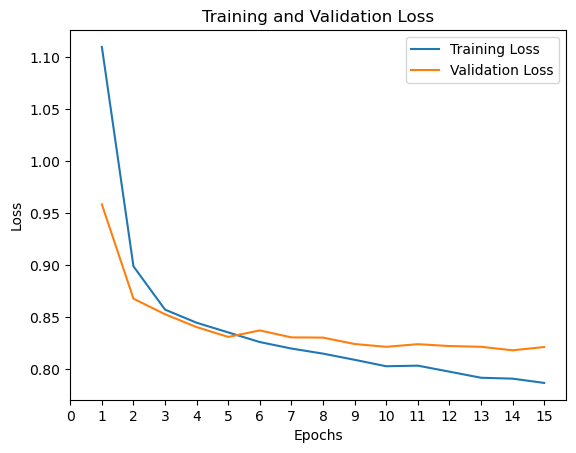

In [65]:
# Generate a sequence of integers to represent the epoch numbers
epochs = range(1, EPOCHS+1)
 
# Plot and label the training and validation loss values
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, valid_losses, label='Validation Loss')
 
# Add in a title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
 
# Set the tick locations
plt.xticks(np.arange(0, EPOCHS+1, 1))
 
# Display the plot
plt.legend(loc='best')
plt.show()

# Inference

In [66]:
model.load_state_dict(torch.load(MODEL_FILE))

<All keys matched successfully>

In [67]:
idx = 8

image, mask = valid_data[idx]
logits_mask = model(image.to(DEVICE).unsqueeze(0)) # (C, H, W) -> (1, C, H, W)
pred_mask = torch.sigmoid(logits_mask)
pred_mask = pred_mask.squeeze(0)

In [68]:
print(f'img shape {image.shape}')
print(f'mask shape {mask.shape}')
print(f'pred_mask shape {pred_mask.shape}')

img shape torch.Size([3, 512, 512])
mask shape torch.Size([1, 512, 512])
pred_mask shape torch.Size([1, 512, 512])


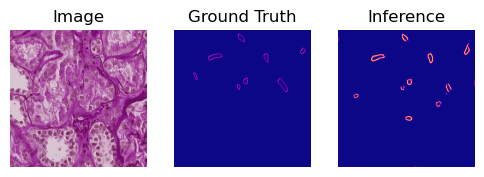

In [69]:
# Plot inference 
n_rows = 1
n_cols = 3
ratio = 2

fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*ratio, n_rows*ratio))

# shape (H, W, C)
image = image.permute(1, 2, 0).cpu().numpy() 
mask = mask.permute(1, 2, 0).cpu().numpy()
pred_mask = pred_mask.permute(1, 2, 0).detach().cpu().numpy()

# Plot
axs[0].imshow(image); axs[0].axis('off')
axs[1].imshow(mask, cmap='plasma'); axs[1].axis('off')
axs[2].imshow(pred_mask, cmap='plasma', interpolation=None); axs[2].axis('off')

# Set subplot title
axs[0].set_title('Image')
axs[1].set_title('Ground Truth')
axs[2].set_title('Inference')

for ax in axs:
    # Hide X and Y axes label marks
    ax.xaxis.set_tick_params(labelbottom=False)
    ax.yaxis.set_tick_params(labelleft=False)

    # Hide X and Y axes tick marks
    ax.set_xticks([])
    ax.set_yticks([])

In [70]:
img_path = '/kaggle/input/hubmap-hacking-the-human-vasculature/test/72e40acccadf.tif'
        
with rasterio.open(img_path) as image:
    image_array = image.read()

In [71]:
!pipreqsnb '/kaggle/working'

pipreqs  /kaggle/working
